In [204]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geoalchemy2 import Geometry, WKTElement
from shapely.geometry import Point, Polygon, MultiPolygon

## Task 1. Import & Clean datasets

### Step 1: load and clean `Business.csv`

In [205]:
# Read CSV with proper dtypes for codes/names
business_orignial = pd.read_csv('Businesses.csv', dtype={
    'industry_code': str,
    'industry_name': str,
    'sa2_code': str,
    'sa2_name': str
})

# Avoid modifying the original dataframe
business = business_orignial.copy()

# Check missing values
print("=== Missing values per column ===")
print(business.isnull().sum())

=== Missing values per column ===
industry_code             0
industry_name             0
sa2_code                  0
sa2_name                  0
0_to_50k_businesses       0
50k_to_200k_businesses    0
200k_to_2m_businesses     0
2m_to_5m_businesses       0
5m_to_10m_businesses      0
10m_or_more_businesses    0
total_businesses          0
dtype: int64


In [206]:
# Ensure the numeric columns are integers
numeric_cols = [
    '0_to_50k_businesses',
    '50k_to_200k_businesses',
    '200k_to_2m_businesses',
    '2m_to_5m_businesses',
    '5m_to_10m_businesses',
    '10m_or_more_businesses',
    'total_businesses'
]
business[numeric_cols] = business[numeric_cols].astype(int)

# Check for duplicates
print("=== Duplicates ===")
print(business.duplicated().sum())
print("=== Duplicates industry_code and sa2_code ===")
print(business.duplicated(subset=['industry_code', 'sa2_code']).sum())

=== Duplicates ===
0
=== Duplicates industry_code and sa2_code ===
0


In [207]:
# Verify that sum of segments equals total_businesses
segment_cols = numeric_cols[:-1]
business['computed_total'] = business[segment_cols].sum(axis=1)
mismatch = business[business['computed_total'] != business['total_businesses']]
print(f"Rows with mismatched total_businesses: {len(mismatch)}")

Rows with mismatched total_businesses: 7275


In [208]:
print(mismatch[['industry_code','sa2_code','computed_total','total_businesses']])

# Replace mismatched total_businesses with computed totals
print("\nReplacing mismatched total_businesses with computed totals...")
business['total_businesses'] = business['computed_total']

# Verify all mismatches are fixed
mismatch_after = business[business['computed_total'] != business['total_businesses']]
print(f"Rows with mismatched total_businesses after correction: {len(mismatch_after)}")

# Final: drop the helper column
business = business.drop(columns=['computed_total'])

      industry_code   sa2_code  computed_total  total_businesses
0                 A  101021007             295               296
2                 A  101021009              16                15
7                 A  101031013             244               246
8                 A  101031014             100                96
9                 A  101031015             248               251
...             ...        ...             ...               ...
12212             S  128021538             151               152
12213             S  128021607              88                87
12214             S  128021608              20                22
12215             S  128021609               8                 9
12216             S  199999499             189               190

[7275 rows x 4 columns]

Replacing mismatched total_businesses with computed totals...
Rows with mismatched total_businesses after correction: 0


In [209]:
# View data types
print("=== Data types ===")
print(business.dtypes)

# Read the dataframe
business.head()

=== Data types ===
industry_code             object
industry_name             object
sa2_code                  object
sa2_name                  object
0_to_50k_businesses        int64
50k_to_200k_businesses     int64
200k_to_2m_businesses      int64
2m_to_5m_businesses        int64
5m_to_10m_businesses       int64
10m_or_more_businesses     int64
total_businesses           int64
dtype: object


,industry_code,industry_name,sa2_code,sa2_name,0_to_50k_businesses,50k_to_200k_businesses,200k_to_2m_businesses,2m_to_5m_businesses,5m_to_10m_businesses,10m_or_more_businesses,total_businesses
0,A,"Agriculture, Forestry and Fishing",101021007,Braidwood,136,92,63,4,0,0,295
1,A,"Agriculture, Forestry and Fishing",101021008,Karabar,6,3,0,0,0,0,9
2,A,"Agriculture, Forestry and Fishing",101021009,Queanbeyan,6,4,3,0,0,3,16
3,A,"Agriculture, Forestry and Fishing",101021010,Queanbeyan - East,0,3,0,0,0,0,3
4,A,"Agriculture, Forestry and Fishing",101021012,Queanbeyan West - Jerrabomberra,7,4,5,0,0,0,16


### Step 2: load and clean `SA2_region` dataset

In [210]:
# Load the SA2 shapefile data
sa2_shapefile_path = 'SA2_2021_AUST_GDA2020.shp'
sa2_gdf_original = gpd.read_file(sa2_shapefile_path)

In [211]:
# Avoid modifying the original dataframe
sa2_gdf = sa2_gdf_original.copy()

# Display basic information about the shapefile
print("=== SA2 Shapefile Information ===")
print(f"Number of SA2 regions: {len(sa2_gdf)}")
print(f"Coordinate Reference System (CRS): {sa2_gdf.crs}")
print("\nColumns in the shapefile:")
print(sa2_gdf.columns.tolist())

# Filter to include only Greater Sydney
sydney_sa2_gdf = sa2_gdf[sa2_gdf['GCC_NAME21'] == 'Greater Sydney']

# Update the main dataframe to only include Sydney
sa2_gdf = sydney_sa2_gdf

=== SA2 Shapefile Information ===
Number of SA2 regions: 2473
Coordinate Reference System (CRS): EPSG:7844

Columns in the shapefile:
['SA2_CODE21', 'SA2_NAME21', 'CHG_FLAG21', 'CHG_LBL21', 'SA3_CODE21', 'SA3_NAME21', 'SA4_CODE21', 'SA4_NAME21', 'GCC_CODE21', 'GCC_NAME21', 'STE_CODE21', 'STE_NAME21', 'AUS_CODE21', 'AUS_NAME21', 'AREASQKM21', 'LOCI_URI21', 'geometry']


In [212]:
# Remove the columns which are not relevant to the analysis
coulmns_to_remove = ['CHG_FLAG21', 'CHG_LBL21', 'SA3_CODE21', 'SA3_NAME21', 'STE_CODE21', 'STE_NAME21', 'AUS_CODE21', 'AUS_NAME21', 'LOCI_URI21']
sa2_gdf.drop(columns=coulmns_to_remove, inplace=True)

# Reset the index
sa2_gdf = sa2_gdf.reset_index(drop=True)

sa2_gdf.head()

,SA2_CODE21,SA2_NAME21,SA4_CODE21,SA4_NAME21,GCC_CODE21,GCC_NAME21,AREASQKM21,geometry
0,102011028,Avoca Beach - Copacabana,102,Central Coast,1GSYD,Greater Sydney,6.4376,"POLYGON ((151.41373 -33.46558, 151.41362 -33.4..."
1,102011029,Box Head - MacMasters Beach,102,Central Coast,1GSYD,Greater Sydney,32.0802,"POLYGON ((151.37484 -33.50052, 151.37507 -33.5..."
2,102011030,Calga - Kulnura,102,Central Coast,1GSYD,Greater Sydney,767.9512,"MULTIPOLYGON (((151.20449 -33.5328, 151.20448 ..."
3,102011031,Erina - Green Point,102,Central Coast,1GSYD,Greater Sydney,33.7934,"POLYGON ((151.37194 -33.43698, 151.37288 -33.4..."
4,102011032,Gosford - Springfield,102,Central Coast,1GSYD,Greater Sydney,16.9123,"POLYGON ((151.32349 -33.42779, 151.32342 -33.4..."


In [213]:
# Check for any issues that may need cleaning
print("=== SA2 Shapefile Data Quality Checks ===")
print("Missing values:")
print(sa2_gdf.isnull().sum())

# Check for invalid geometries
print("\nInvalid geometries:")
invalid_geoms = sa2_gdf[~sa2_gdf.geometry.is_valid]
print(f"Number of invalid geometries: {len(invalid_geoms)}")
if len(invalid_geoms) > 0:
    print(invalid_geoms[['SA2_CODE21', 'SA2_NAME21']])

# Check for duplicate SA2 codes
print("\nDuplicate SA2 codes:")
duplicate_sa2_codes = sa2_gdf[sa2_gdf.duplicated(subset=['SA2_CODE21'], keep=False)]
print(f"Number of duplicate SA2 codes: {len(duplicate_sa2_codes)}")
if len(duplicate_sa2_codes) > 0:
    print(duplicate_sa2_codes[['SA2_CODE21', 'SA2_NAME21']])

=== SA2 Shapefile Data Quality Checks ===
Missing values:
SA2_CODE21    0
SA2_NAME21    0
SA4_CODE21    0
SA4_NAME21    0
GCC_CODE21    0
GCC_NAME21    0
AREASQKM21    0
geometry      0
dtype: int64

Invalid geometries:
Number of invalid geometries: 0

Duplicate SA2 codes:
Number of duplicate SA2 codes: 0


In [214]:
# Get a list of all columns except geometry
non_geom_columns = [col for col in sa2_gdf.columns if col != 'geometry']

# Ensure all non-geometry columns of type are string, except 'AREASQKM21'
for col in non_geom_columns:
    if col != 'AREASQKM21':
        sa2_gdf[col] = sa2_gdf[col].astype(str)

# Create a dictionary to rename columns
rename_dict = {}
for col in sa2_gdf.columns:
    if col != 'geometry':
        # Remove '21' suffix if present and convert to lowercase
        new_name = col.lower().replace('21', '') if col.endswith('21') else col.lower()
        rename_dict[col] = new_name

# Rename the columns
sa2_gdf = sa2_gdf.rename(columns=rename_dict)

print(f"Number of SA2 regions: {len(sa2_gdf)}")
print("Columns in the cleaned shapefile:")
print(sa2_gdf.columns.tolist())

Number of SA2 regions: 373
Columns in the cleaned shapefile:
['sa2_code', 'sa2_name', 'sa4_code', 'sa4_name', 'gcc_code', 'gcc_name', 'areasqkm', 'geometry']


<Figure size 1200x1000 with 0 Axes>

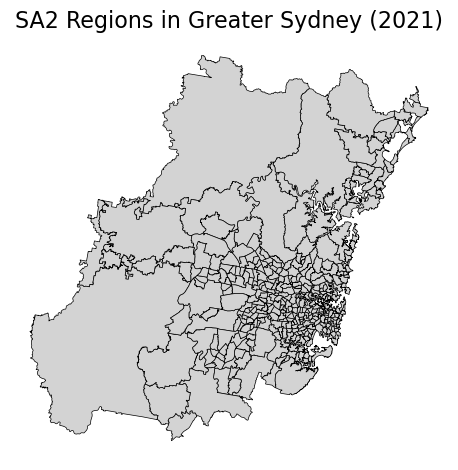

In [215]:
# Visualize the SA2 regions with light fill and clear boundaries
plt.figure(figsize=(12, 10))
sa2_gdf.plot(
    color='lightgray',  # Single light color for all regions
    edgecolor='black',
    linewidth=0.5
)
plt.title('SA2 Regions in Greater Sydney (2021)', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

In [216]:
# This function is used to wrap the geometry column with WKTElement for the polygon data
def create_wkt_element(geom):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return geom.wkt

### Step 3: load and clean `Stops.csv`

In [217]:
# Define the file path for the new dataset
stops_file_path = 'Stops.txt'

# Load the dataset
stops_df_original = pd.read_csv(stops_file_path, sep = ',', quotechar= '"')

# Check missing values
print("=== Missing values per column ===")
print(stops_df_original.isnull().sum())

# Display the first few rows
stops_df_original.head()

=== Missing values per column ===
stop_id                     0
stop_code               53999
stop_name                   0
stop_lat                    0
stop_lon                    0
location_type           60727
parent_station          53991
wheelchair_boarding         0
platform_code          113847
dtype: int64


,stop_id,stop_code,stop_name,stop_lat,stop_lon,location_type,parent_station,wheelchair_boarding,platform_code
0,200039,200039.0,"Central Station, Eddy Av, Stand A",-33.882206,151.206665,NaN,200060,0,NaN
1,200054,200054.0,"Central Station, Eddy Av, Stand D",-33.882042,151.206991,NaN,200060,0,NaN
2,200060,NaN,Central Station,-33.884084,151.206292,1.0,NaN,0,NaN
3,201510,NaN,Redfern Station,-33.891690,151.198866,1.0,NaN,0,NaN
4,201646,201646.0,"Redfern Station, Gibbons St, Stand B",-33.893329,151.198882,NaN,201510,0,NaN


In [218]:
# Avoid modifying the original dataframe
stops_df = stops_df_original.copy()

# Handle Missing Values
critical_cols = ['stop_id', 'stop_name', 'stop_lat', 'stop_lon']
initial_rows = len(stops_df)
stops_df.dropna(subset=critical_cols, inplace=True)
print("=== Missing value rows dropped ===")
print(f"Dropped {initial_rows - len(stops_df)} rows")


=== Missing value rows dropped ===
Dropped 0 rows


In [219]:
# Drop columns which are not relevant to the analysis
cols_to__drop = ['stop_code', 'location_type', 'parent_station', 'platform_code', 'wheelchair_boarding']
stops_df.drop(columns=cols_to__drop, inplace=True)
stops_df.head()

,stop_id,stop_name,stop_lat,stop_lon
0,200039,"Central Station, Eddy Av, Stand A",-33.882206,151.206665
1,200054,"Central Station, Eddy Av, Stand D",-33.882042,151.206991
2,200060,Central Station,-33.884084,151.206292
3,201510,Redfern Station,-33.891690,151.198866
4,201646,"Redfern Station, Gibbons St, Stand B",-33.893329,151.198882


In [220]:
# Check/Correct Data Types (Example)
print("=== Data types ===")
print(stops_df.dtypes)

=== Data types ===
stop_id       object
stop_name     object
stop_lat     float64
stop_lon     float64
dtype: object


In [221]:
dup_rows = stops_df[stops_df.duplicated(subset=['stop_id'], keep=False)]

# How many total rows are in these duplicate groups?
print("=== Duplicate stop_id ===")
print(f"Found {len(dup_rows)} rows belonging to duplicate stop_id values.")

=== Duplicate stop_id ===
Found 0 rows belonging to duplicate stop_id values.


In [222]:
# Combine the lat and lon as geometry
stops_df['geometry'] = gpd.points_from_xy(stops_df.stop_lon, stops_df.stop_lat)
stops_df = stops_df.drop(columns=['stop_lon', 'stop_lat'])

stops_df['geometry'] = stops_df['geometry'].apply(lambda x: x.wkt)
stops_df.head()

,stop_id,stop_name,geometry
0,200039,"Central Station, Eddy Av, Stand A",POINT (151.20666465471 -33.8822064874687)
1,200054,"Central Station, Eddy Av, Stand D",POINT (151.20699145565 -33.8820421431408)
2,200060,Central Station,POINT (151.206292455081 -33.8840842535493)
3,201510,Redfern Station,POINT (151.198866071817 -33.8916900512711)
4,201646,"Redfern Station, Gibbons St, Stand B",POINT (151.198881722942 -33.8933293130144)


### Step 4: load and clean `Schools` datasets

In [223]:
# Load the Schools shapefile data
future_school_shapefile_path = 'catchments/catchments_future.shp'
future_gdf_original = gpd.read_file(future_school_shapefile_path)

primary_school_shapefile_path = 'catchments/catchments_primary.shp'
primary_gdf_original = gpd.read_file(primary_school_shapefile_path)

secondary_school_shapefile_path = 'catchments/catchments_secondary.shp'
secondary_gdf_original = gpd.read_file(secondary_school_shapefile_path)

In [224]:
# Avoid modifying the original dataframe
future_gdf = future_gdf_original.copy()
primary_gdf = primary_gdf_original.copy()
secondary_gdf = secondary_gdf_original.copy()

# Remove all columns are not relevant to the analysis
cols_to_remove = ['ADD_DATE','KINDERGART', 'YEAR1','YEAR2', 'YEAR3', 'YEAR4', 'YEAR5', 'YEAR6', 'YEAR7', 'YEAR8', 'YEAR9', 'YEAR10', 'YEAR11', 'YEAR12']
future_gdf.drop(columns=cols_to_remove, inplace=True)
primary_gdf.drop(columns=cols_to_remove + ['PRIORITY'], inplace=True)
secondary_gdf.drop(columns=cols_to_remove + ['PRIORITY'], inplace=True)

# Concatenate the three GeoDataFrames
schools_gdf = pd.concat([future_gdf, primary_gdf, secondary_gdf], ignore_index=True)

# Display the first few rows and info of the merged dataframe to verify
print("\n=== Head of schools_gdf ===")
schools_gdf


=== Head of schools_gdf ===


,USE_ID,CATCH_TYPE,USE_DESC,geometry
0,8416,HIGH_COED,Ku-ring-gai HS,"POLYGON ((151.19849 -33.5399, 151.19945 -33.54..."
1,8161,HIGH_BOYS,Randwick BHS,"POLYGON ((151.27152 -33.91402, 151.27152 -33.9..."
2,8539,HIGH_COED,SSC Blackwattle Bay,"POLYGON ((151.15292 -33.83939, 151.16144 -33.8..."
3,8400,HIGH_COED,St Ives HS,"POLYGON ((151.17794 -33.6982, 151.17859 -33.69..."
4,8555,HIGH_COED,Rose Bay SC,"POLYGON ((151.28072 -33.83287, 151.28095 -33.8..."
...,...,...,...,...
2123,8213,HIGH_BOYS,Birrong BHS,"POLYGON ((151.05364 -33.85076, 151.06142 -33.8..."
2124,8108,HIGH_COED,Cessnock HS,"POLYGON ((151.42852 -32.74415, 151.4308 -32.75..."
2125,3235,CENTRAL_HIGH,Tooleybuc CS,"POLYGON ((143.37723 -34.80173, 143.39037 -34.8..."
2126,1115,CENTRAL_HIGH,Balranald CS,"POLYGON ((143.65541 -33.55702, 143.65541 -33.5..."


#### === Check if the rows with same id have same geometry ===

In [225]:
# List unique CATCH_TYPE values
unique_catch_types = schools_gdf['CATCH_TYPE'].unique()
print("\n=== Unique CATCH_TYPE values in schools_gdf ===")
print(unique_catch_types)

# Remove rows where both USE_ID and geometry are identical duplicates
print(f"\nOriginal number of rows in schools_gdf: {len(schools_gdf)}")
duplicate_check_columns = ['USE_ID', 'geometry']
schools_gdf.drop_duplicates(subset=duplicate_check_columns, keep='first', inplace=True)

print(f"Number of rows after removing duplicates based on {duplicate_check_columns}: {len(schools_gdf)}")

# Remove rows that are completely duplicated across all columns
print(f"\nShape before removing duplicates: {schools_gdf.shape}")
schools_gdf.drop_duplicates(inplace=True)
print(f"Shape after removing duplicates: {schools_gdf.shape}")


=== Unique CATCH_TYPE values in schools_gdf ===
['HIGH_COED' 'HIGH_BOYS' 'CENTRAL_HIGH' 'HIGH_GIRLS' 'PRIMARY' 'INFANTS'
 'CENTRAL_PRIMARY']

Original number of rows in schools_gdf: 2128
Number of rows after removing duplicates based on ['USE_ID', 'geometry']: 2096

Shape before removing duplicates: (2096, 4)
Shape after removing duplicates: (2096, 4)


In [226]:
# Check the CRS of the schools_gdf
print(schools_gdf.crs)

EPSG:4283


In [227]:
# Convert the CRS to EPSG: 7844
schools_gdf = schools_gdf.to_crs(epsg=7844)
print(schools_gdf.crs)

EPSG:7844


In [228]:
# Wrap the geometry column with WKTElement
schools_gdf['geom'] = schools_gdf['geometry'].apply(lambda x: create_wkt_element(geom=x))  # applying the function
schools_gdf = schools_gdf.drop(columns="geometry")
schools_gdf.head()

,USE_ID,CATCH_TYPE,USE_DESC,geom
0,8416,HIGH_COED,Ku-ring-gai HS,MULTIPOLYGON (((151.19849465239312 -33.5398860...
1,8161,HIGH_BOYS,Randwick BHS,MULTIPOLYGON (((151.2715207191065 -33.91400564...
2,8539,HIGH_COED,SSC Blackwattle Bay,MULTIPOLYGON (((151.1529291511585 -33.83937945...
3,8400,HIGH_COED,St Ives HS,MULTIPOLYGON (((151.17794275650013 -33.6981874...
4,8555,HIGH_COED,Rose Bay SC,MULTIPOLYGON (((151.28072818401563 -33.8328602...


In [229]:
schools_gdf = schools_gdf.rename(columns={
    'USE_ID': 'school_code',
    'CATCH_TYPE': 'catchment_type',
    'USE_DESC': 'school_name',
    'geom': 'geometry'
})

# Display the first few rows to confirm changes
print("=== schools_gdf after renaming columns: ===")
display(schools_gdf.head())


=== schools_gdf after renaming columns: ===


,school_code,catchment_type,school_name,geometry
0,8416,HIGH_COED,Ku-ring-gai HS,MULTIPOLYGON (((151.19849465239312 -33.5398860...
1,8161,HIGH_BOYS,Randwick BHS,MULTIPOLYGON (((151.2715207191065 -33.91400564...
2,8539,HIGH_COED,SSC Blackwattle Bay,MULTIPOLYGON (((151.1529291511585 -33.83937945...
3,8400,HIGH_COED,St Ives HS,MULTIPOLYGON (((151.17794275650013 -33.6981874...
4,8555,HIGH_COED,Rose Bay SC,MULTIPOLYGON (((151.28072818401563 -33.8328602...


### Step 5: Load and clean `Population.csv`

In [230]:
population_file_path = 'Population.csv'

# Load the dataset
population_df_original = pd.read_csv(population_file_path)
population_df = population_df_original.copy() # Work on a copy
print("=== Population.csv loaded successfully ===")
print(f"Shape of the dataframe: {population_df.shape}")

print("\n=== First 5 rows: ===")
display(population_df.head())

    
print("\n=== Data types: ===")
population_df.info() # .info() prints directly to stdout

print("\n=== Missing values per column: ===")
# Similarly, display() or print() for the Series of null counts
display(population_df.isnull().sum())

print("\n=== Duplicates ===")
print(population_df.duplicated().sum())


=== Population.csv loaded successfully ===
Shape of the dataframe: (373, 21)

=== First 5 rows: ===


,sa2_code,sa2_name,0-4_people,5-9_people,10-14_people,15-19_people,20-24_people,25-29_people,30-34_people,35-39_people,...,45-49_people,50-54_people,55-59_people,60-64_people,65-69_people,70-74_people,75-79_people,80-84_people,85-and-over_people,total_people
0,102011028,Avoca Beach - Copacabana,424,522,623,552,386,222,306,416,...,572,602,570,520,464,369,226,142,70,7530
1,102011029,Box Head - MacMasters Beach,511,666,702,592,461,347,420,535,...,749,749,794,895,863,925,603,331,264,11052
2,102011030,Calga - Kulnura,200,225,258,278,274,227,214,286,...,325,436,422,397,327,264,190,100,75,4748
3,102011031,Erina - Green Point,683,804,880,838,661,502,587,757,...,859,882,901,930,917,1065,976,773,1028,14803
4,102011032,Gosford - Springfield,1164,1044,1084,1072,1499,1864,1750,1520,...,1330,1241,1377,1285,1166,949,664,476,537,21346



=== Data types: ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   sa2_code            373 non-null    int64 
 1   sa2_name            373 non-null    object
 2   0-4_people          373 non-null    int64 
 3   5-9_people          373 non-null    int64 
 4   10-14_people        373 non-null    int64 
 5   15-19_people        373 non-null    int64 
 6   20-24_people        373 non-null    int64 
 7   25-29_people        373 non-null    int64 
 8   30-34_people        373 non-null    int64 
 9   35-39_people        373 non-null    int64 
 10  40-44_people        373 non-null    int64 
 11  45-49_people        373 non-null    int64 
 12  50-54_people        373 non-null    int64 
 13  55-59_people        373 non-null    int64 
 14  60-64_people        373 non-null    int64 
 15  65-69_people        373 non-null    int64 
 16  70-74

sa2_code              0
sa2_name              0
0-4_people            0
5-9_people            0
10-14_people          0
15-19_people          0
20-24_people          0
25-29_people          0
30-34_people          0
35-39_people          0
40-44_people          0
45-49_people          0
50-54_people          0
55-59_people          0
60-64_people          0
65-69_people          0
70-74_people          0
75-79_people          0
80-84_people          0
85-and-over_people    0
total_people          0
dtype: int64


=== Duplicates ===
0


In [231]:
# Verify that sum of segments equals total_people
segment_cols = population_df.columns[2:20]
population_df['computed_total'] = population_df[segment_cols].sum(axis=1)
mismatch = population_df[population_df['computed_total'] != population_df['total_people']]
print(f"Rows with mismatched total_people: {len(mismatch)}")

Rows with mismatched total_people: 0


In [232]:
# remove the computed_total column
population_df = population_df.drop(columns=['computed_total'])

# Keep only rows where 'total_people' is greater than or equal to 100
population_df = population_df.loc[population_df['total_people'] >= 100]
print(f"Rows after filtering: {len(population_df)}")

Rows after filtering: 360


### Step 6: Load and clean `Income.csv`

In [233]:
income_file_path = 'Income.csv'

income_df_original = pd.read_csv(income_file_path, dtype={
    'SA2_CODE_2021': str})
income_df = income_df_original.copy() # Work on a copy

print("=== Income.csv loaded successfully ===")
print(f"Shape of the dataframe: {income_df.shape}")
print("\n=== First 5 rows: ===")
display(income_df.head())


=== Income.csv loaded successfully ===
Shape of the dataframe: (642, 6)

=== First 5 rows: ===


,sa2_code21,sa2_name,earners,median_age,median_income,mean_income
0,101021007,Braidwood,2467,51,46640,68904
1,101021008,Karabar,5103,42,65564,69672
2,101021009,Queanbeyan,7028,39,63528,69174
3,101021010,Queanbeyan - East,3398,39,66148,74162
4,101021012,Queanbeyan West - Jerrabomberra,8422,44,78630,91981


In [234]:
print("\n=== Data types: ===")
income_df.info()

print("\n=== Missing values per column: ===")
display(income_df.isnull().sum())

print("\n=== Duplicates before any cleaning: ===")
print(f"Number of duplicate rows: {income_df.duplicated().sum()}")



=== Data types: ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642 entries, 0 to 641
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   sa2_code21     642 non-null    int64 
 1   sa2_name       642 non-null    object
 2   earners        642 non-null    object
 3   median_age     642 non-null    object
 4   median_income  642 non-null    object
 5   mean_income    642 non-null    object
dtypes: int64(1), object(5)
memory usage: 30.2+ KB

=== Missing values per column: ===


sa2_code21       0
sa2_name         0
earners          0
median_age       0
median_income    0
mean_income      0
dtype: int64


=== Duplicates before any cleaning: ===
Number of duplicate rows: 0


In [235]:
# Columns that are expected to be numeric
income_num_cols = income_df.columns[2:]

for col in income_num_cols:
    income_df[col] = pd.to_numeric(income_df[col], errors='coerce')

    print("\n=== Missing values in the column: ===")
    print(f"Column: {income_df[col].isnull().sum()}")

    mean_val = income_df[col].mean()

    income_df[col] = income_df[col].fillna(mean_val).astype(int)

    print("\n=== Missing values in the column(after filling): ===")
    print(f"Column: {income_df[col].isnull().sum()}")


=== Missing values in the column: ===
Column: 7

=== Missing values in the column(after filling): ===
Column: 0

=== Missing values in the column: ===
Column: 7

=== Missing values in the column(after filling): ===
Column: 0

=== Missing values in the column: ===
Column: 7

=== Missing values in the column(after filling): ===
Column: 0

=== Missing values in the column: ===
Column: 7

=== Missing values in the column(after filling): ===
Column: 0


In [236]:
rename_map = {'sa2_code21': 'sa2_code'}

income_df.rename(columns=rename_map, inplace=True)
print("\n=== Column names after initial rename attempt: ===")
print(list(income_df.columns))


=== Column names after initial rename attempt: ===
['sa2_code', 'sa2_name', 'earners', 'median_age', 'median_income', 'mean_income']


## Task 2: NSW Points of Interest API

**Task 2.i:** Develop a function that returns all points of interests from the API within a specified bounding box.

In [237]:
import requests
import json
import time

def get_poi_by_bbox(bbox, filters=None):
    """
    Fetches Points of Interest (POIs) from the NSW POI API within a specified bounding box.

    Args:
        bbox (dict): A dictionary defining the bounding box with keys 
                     'xmin', 'ymin', 'xmax', 'ymax'.
        filters (dict, optional): Additional filters for the API query. Defaults to None.

    Returns:
        list: A list of POI features if the request is successful, otherwise None.
              Each feature is a dictionary.
    """
    base_url = 'https://maps.six.nsw.gov.au/arcgis/rest/services/public/NSW_POI/MapServer/0/query'
    
    # The API expects the geometry parameter as a string like:
    # "xmin:150.0,ymin:-34.0,xmax:151.0,ymax:-33.0"
    # Ensure bbox values are rounded or formatted as needed if they come from GeoDataFrame bounds
    geometry_param = f"\"xmin\":{bbox['xmin']},\"ymin\":{bbox['ymin']},\"xmax\":{bbox['xmax']},\"ymax\":{bbox['ymax']}"
    
    params = {
        'geometry': geometry_param,
        'geometryType': 'esriGeometryEnvelope', # Specify that the geometry is a bounding box
        'inSR': '7844', 
        'outFields': '*', # Request all fields
        'returnGeometry': 'true', # Request geometry for the POIs
        'outSR': '7844', # Request POI geometry in GDA94
        'f': 'json' # Request format
    }

    if filters:
        params.update(filters)

    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status() # Raises an HTTPError for bad responses (4XX or 5XX)
        data = response.json()
        if 'features' in data:
            return data['features']
        else:
            print(f"Warning: 'features' not found in API response for bbox {bbox}. Response: {data}")
            return [] # Return empty list if features are missing but no error raised
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred: {http_err}")
        print(f"Request URL: {response.url}") # Print the failing URL for debugging
        print(f"Response content: {response.text}")
        return None
    except requests.exceptions.RequestException as req_err:
        print(f"Request error occurred: {req_err}")
        return None
    except json.JSONDecodeError:
        print("Error decoding JSON from API response.")
        print(f"Response content: {response.text}")
        return None

In [238]:
# Find the sa4_code for Northern Beaches
try:
    northern_beaches_code = sa2_gdf[sa2_gdf['sa4_name'] == 'Sydney - Northern Beaches']['sa4_code'].unique()
    if len(northern_beaches_code) > 0:
        nb_code = northern_beaches_code[0]
        print(f"The sa4_code for 'Northern Beaches' is: {nb_code}")
    else:
        print("Could not find sa4_code for 'Northern Beaches'. Available SA4 names:")
        print(sa2_gdf['sa4_name'].unique())
        nb_code = None # Set to None if not found
except NameError:
    print("Error: sa2_gdf is not defined. Make sure the preceding cells are executed.")
    nb_code = None
except KeyError:
    print("Error: 'sa4_name' or 'sa4_code' column not found in sa2_gdf.")
    nb_code = None

The sa4_code for 'Northern Beaches' is: 122


In [239]:
# Task 2.ii: Loop through SA2 regions in the selected SA4, get POIs using bounding box

# Define the selected SA4 code (found in the previous cell)
selected_sa4_code = '122' # For Sydney - Northern Beaches
selected_sa4_name = 'Sydney - Northern Beaches'

# Filter sa2_gdf for the selected SA4 region
# Make sure sa2_gdf is the version after cell [40] (Greater Sydney, cleaned columns, shapely geometry)
sa2_in_selected_sa4 = sa2_gdf[sa2_gdf['sa4_code'] == selected_sa4_code].copy()

print(f"Processing {len(sa2_in_selected_sa4)} SA2 regions in SA4: {selected_sa4_name} ({selected_sa4_code})")

# --- Calculate bounding boxes --- 
# The .bounds property gives (minx, miny, maxx, maxy)
sa2_in_selected_sa4['bbox_coords'] = sa2_in_selected_sa4.geometry.apply(lambda geom: geom.bounds)

# --- Loop through SA2s and fetch POIs --- 
all_pois_in_selected_sa4 = [] # List to store all POIs found

for index, row in sa2_in_selected_sa4.iterrows():
    sa2_code = row['sa2_code']
    sa2_name = row['sa2_name']
    bounds = row['bbox_coords']
    sa2_geometry = row['geometry'] 
    
    # Format the bounding box for the API function
    bbox_dict = {'xmin': bounds[0], 'ymin': bounds[1], 'xmax': bounds[2], 'ymax': bounds[3]}
    
    print(f"\nFetching POIs for SA2: {sa2_name} ({sa2_code}) using bbox...")
    
    # Wait for 1 second before the API call
    time.sleep(1) 
    
    # Ensure the get_poi_by_bbox function is defined and works correctly
    try:
        pois = get_poi_by_bbox(bbox_dict) 
        
        if pois is not None: # Check if the API call returned data (even if empty list)
            pois_in_sa2_boundary = [] # Temp list for POIs truly within the SA2 boundary
            for poi in pois:
                try:
                    # Check if geometry exists and has x, y coordinates
                    if 'geometry' in poi and poi['geometry'] and 'x' in poi['geometry'] and 'y' in poi['geometry']:
                        # Create a shapely Point from the POI coordinates
                        poi_point = Point(poi['geometry']['x'], poi['geometry']['y'])
                        
                        # Check if the POI point is within the actual SA2 polygon
                        if sa2_geometry.contains(poi_point):
                            # Add source SA2 information
                            if 'attributes' in poi:
                                poi['attributes']['sa2_code_source'] = sa2_code
                                poi['attributes']['sa2_name_source'] = sa2_name
                            else:
                                # Handle POIs that might lack an 'attributes' dictionary
                                poi['attributes'] = {'sa2_code_source': sa2_code, 'sa2_name_source': sa2_name}
                            pois_in_sa2_boundary.append(poi)
                    else:
                         print(f"- Warning: POI with missing/invalid geometry skipped: {poi.get('attributes', {}).get('objectid', 'N/A')}")

                except Exception as check_err:
                    print(f"- Error checking containment for POI {poi.get('attributes', {}).get('objectid', 'N/A')}: {check_err}")

            print(f"---> Found {len(pois)} POIs within BBox, kept {len(pois_in_sa2_boundary)} POIs within actual SA2 boundary for {sa2_name}")
            all_pois_in_selected_sa4.extend(pois_in_sa2_boundary) # Extend with the filtered list
            
        else:
            # This case handles if get_poi_by_bbox returned None due to an error
            print(f"---> Error fetching POIs for {sa2_name}. Skipping this SA2.")
            
    except Exception as e:
        # Catch any unexpected error during the API call for a specific SA2
        print(f"---> An unexpected error occurred fetching POIs for {sa2_name}: {e}")
        print("---> Skipping this SA2.")

print(f"\n\nFinished processing all SA2 regions in {selected_sa4_name}.")
print(f"Total POIs collected: {len(all_pois_in_selected_sa4)}")

Processing 19 SA2 regions in SA4: Sydney - Northern Beaches (122)

Fetching POIs for SA2: Balgowlah - Clontarf - Seaforth (122011418) using bbox...
---> Found 205 POIs within BBox, kept 87 POIs within actual SA2 boundary for Balgowlah - Clontarf - Seaforth

Fetching POIs for SA2: Manly - Fairlight (122011419) using bbox...
---> Found 196 POIs within BBox, kept 126 POIs within actual SA2 boundary for Manly - Fairlight

Fetching POIs for SA2: Avalon - Palm Beach (122021420) using bbox...
---> Found 186 POIs within BBox, kept 138 POIs within actual SA2 boundary for Avalon - Palm Beach

Fetching POIs for SA2: Bayview - Elanora Heights (122021421) using bbox...
---> Found 679 POIs within BBox, kept 221 POIs within actual SA2 boundary for Bayview - Elanora Heights

Fetching POIs for SA2: Newport - Bilgola (122021422) using bbox...
---> Found 278 POIs within BBox, kept 210 POIs within actual SA2 boundary for Newport - Bilgola

Fetching POIs for SA2: Mona Vale - Warriewood (North) (122021690) 

In [254]:

# --- Task 2.iii  --- 
# Next steps would involve processing 'all_pois_in_selected_sa4',
# converting it to a GeoDataFrame, cleaning, 
# and ingesting it into the database.

# Extract attributes, handle potential missing 'attributes' key
poi_attributes_list = []
for poi in all_pois_in_selected_sa4:
    if 'attributes' in poi:
        poi_attributes_list.append(poi['attributes'])
    else:
        # Append a dictionary with at least source info if attributes are missing
        # This maintains alignment if geometry exists but attributes don't
        poi_attributes_list.append({'sa2_code_source': 'N/A', 'sa2_name_source': 'N/A'}) # Placeholder
        print(f"Warning: POI found with missing 'attributes'. POI data: {poi}")

poi_df = pd.DataFrame(poi_attributes_list)

poi_geometries = [Point(poi['geometry']['x'], poi['geometry']['y']) if poi.get('geometry') else None for poi in all_pois_in_selected_sa4]
poi_gdf_original = gpd.GeoDataFrame(poi_df, geometry=poi_geometries, crs="EPSG:7844")
poi_gdf = poi_gdf_original.copy()

print("\n=== POI DataFrame Types ===")
print(poi_gdf.dtypes)

print("\n=== POI DataFrame Head ===")
poi_gdf.head()


=== POI DataFrame Types ===
objectid                  int64
topoid                    int64
poigroup                  int64
poitype                  object
poiname                  object
poilabel                 object
poilabeltype             object
poialtlabel              object
poisourcefeatureoid       int64
accesscontrol             int64
startdate                 int64
enddate                   int64
lastupdate                int64
msoid                     int64
centroidid               object
shapeuuid                object
changetype               object
processstate             object
urbanity                 object
sa2_code_source          object
sa2_name_source          object
geometry               geometry
dtype: object

=== POI DataFrame Head ===


,objectid,topoid,poigroup,poitype,poiname,poilabel,poilabeltype,poialtlabel,poisourcefeatureoid,accesscontrol,...,lastupdate,msoid,centroidid,shapeuuid,changetype,processstate,urbanity,sa2_code_source,sa2_name_source,geometry
0,1094,500188493,1,Place Of Worship,None,METHODIST CHURCH,DERIVED,METHODIST,19,1,...,1285588392535,59793,None,21503b00-7b32-3f2d-89cf-0fa39ed828f0,I,None,U,122011418,Balgowlah - Clontarf - Seaforth,POINT (151.24686 -33.79747)
1,1096,500188560,3,Park,BANTRY RESERVE,BANTRY RESERVE,NAMED,None,61,1,...,1285588392535,84789,None,e5c51aec-bc1d-355e-bfb7-b4ce8219c13b,I,None,S,122011418,Balgowlah - Clontarf - Seaforth,POINT (151.24156 -33.78095)
2,1098,500188604,3,Park,BLIGH PARK,BLIGH PARK,NAMED,None,61,1,...,1285588392535,87887,None,f0866843-99be-386e-bb0d-344300537318,I,None,U,122011418,Balgowlah - Clontarf - Seaforth,POINT (151.24179 -33.78326)
3,2331,500277733,3,Park,MANLY WEST PARK,MANLY WEST PARK,NAMED,None,61,1,...,1414581788737,169809,None,a309b796-bccc-348a-8712-e4ccc417d972,M,None,U,122011418,Balgowlah - Clontarf - Seaforth,POINT (151.26916 -33.78868)
4,2418,500279477,3,Lookout,None,Lookout,GENERIC,None,56,1,...,1285588392535,83376,None,c3d77774-4544-3103-a4e4-aae004a3a96a,I,None,S,122011418,Balgowlah - Clontarf - Seaforth,POINT (151.26399 -33.81252)


In [255]:
# Task 3 Prep: Remove unnecessary columns from poi_gdf for POI analysis

# Define the list of columns to remove
columns_to_remove = [
    'objectid', 'poilabeltype', 'poialtlabel', 'poisourcefeatureoid', 'accesscontrol',
    'suburbname', 'postcode', 'state', 'address', 'phonenumber', 'website', 'comment',
    'attributesource', 'attributedate', 'planimetricaccuracy', 'heightaccuracy',
    'featurecode', 'featuredescription', 'functiontype', 'functiondescription',
    'hierarchylevel', 'subhierarchylevel', 'source', 'capturedate', 'editdate',
    'editreason', 'lastupdate', 'msoid', 'centroidid', 'shapeuuid',
    'changetype', 'processstate', 'urbanity', 'startdate',	'enddate'
]

# Check which of these columns actually exist in the DataFrame to avoid errors
existing_columns_to_remove = [col for col in columns_to_remove if col in poi_gdf.columns]


poi_gdf_cleaned = poi_gdf.drop(columns=existing_columns_to_remove)
print(f"Removed {len(existing_columns_to_remove)} columns. Kept columns: {list(poi_gdf_cleaned.columns)}")


# For subsequent steps, use poi_gdf_cleaned
# Example: Display number of unique POI groups
if 'poigroup' in poi_gdf_cleaned.columns:
    print("\nUnique POI groups present:")
    print(poi_gdf_cleaned['poigroup'].value_counts().sort_index())
else:
    print("\n'poigroup' column not found in the cleaned DataFrame.")

print("\n=== Cleaned POI DataFrame Head ===")
poi_gdf_cleaned['geom'] = poi_gdf_cleaned['geometry'].apply(lambda x: x.wkt)
poi_gdf_cleaned = poi_gdf_cleaned.drop(columns=['geometry'])
poi_gdf_cleaned.rename(columns={'geom': 'geometry'}, inplace=True)
poi_gdf_cleaned.head()


Removed 14 columns. Kept columns: ['topoid', 'poigroup', 'poitype', 'poiname', 'poilabel', 'sa2_code_source', 'sa2_name_source', 'geometry']

Unique POI groups present:
poigroup
1    388
2    100
3    788
4    232
5     14
6     50
7     69
8     89
9      2
Name: count, dtype: int64

=== Cleaned POI DataFrame Head ===


,topoid,poigroup,poitype,poiname,poilabel,sa2_code_source,sa2_name_source,geometry
0,500188493,1,Place Of Worship,None,METHODIST CHURCH,122011418,Balgowlah - Clontarf - Seaforth,POINT (151.24686073319117 -33.79746716852512)
1,500188560,3,Park,BANTRY RESERVE,BANTRY RESERVE,122011418,Balgowlah - Clontarf - Seaforth,POINT (151.2415589248933 -33.78094851658314)
2,500188604,3,Park,BLIGH PARK,BLIGH PARK,122011418,Balgowlah - Clontarf - Seaforth,POINT (151.241787317961 -33.78325780819822)
3,500277733,3,Park,MANLY WEST PARK,MANLY WEST PARK,122011418,Balgowlah - Clontarf - Seaforth,POINT (151.26915669665914 -33.78867636360695)
4,500279477,3,Lookout,None,Lookout,122011418,Balgowlah - Clontarf - Seaforth,POINT (151.26399062110576 -33.81251675790413)


In [258]:
poi_gdf_cleaned[poi_gdf_cleaned['topoid'] == 500188493]

,topoid,poigroup,poitype,poiname,poilabel,sa2_code_source,sa2_name_source,geometry
0,500188493,1,Place Of Worship,None,METHODIST CHURCH,122011418,Balgowlah - Clontarf - Seaforth,POINT (151.24686073319117 -33.79746716852512)


#### Connect with the database

In [242]:
from sqlalchemy import create_engine, text
import psycopg2
import psycopg2.extras
import json

credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        port       = db_conn_dict['port']
        try:
            db = create_engine(f'postgresql+psycopg2://{db_user}:{db_pw}@{host}:{port}/{default_db}', echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(text(sqlcmd), args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

In [243]:
db, conn = pgconnect(credentials)

Connected successfully.


In [244]:
# Wrap the geometry column with WKTElement
sa2_gdf['geom'] = sa2_gdf['geometry'].apply(lambda x: create_wkt_element(geom=x))  # applying the function
sa2_gdf = sa2_gdf.drop(columns="geometry")
print(sa2_gdf.dtypes)

sa2_code     object
sa2_name     object
sa4_code     object
sa4_name     object
gcc_code     object
gcc_name     object
areasqkm    float64
geom         object
dtype: object


In [259]:
table_creation_statements = [
        """
        CREATE TABLE IF NOT EXISTS sa2_regions (
            sa2_code TEXT PRIMARY KEY,
            sa2_name TEXT,
            sa4_code TEXT,
            sa4_name TEXT,
            gcc_code TEXT,
            gcc_name TEXT,
            areasqkm FLOAT,
            geom GEOMETRY(MULTIPOLYGON, 7844) NOT NULL
        );
        """,
        """
        CREATE TABLE IF NOT EXISTS businesses (
            industry_code TEXT NOT NULL,
            industry_name TEXT,
            sa2_code TEXT NOT NULL,
            sa2_name TEXT,
            "0_to_50k_businesses" INTEGER,
            "50k_to_200k_businesses" INTEGER,
            "200k_to_2m_businesses" INTEGER,
            "2m_to_5m_businesses" INTEGER,
            "5m_to_10m_businesses" INTEGER,
            "10m_or_more_businesses" INTEGER,
            total_businesses INTEGER,
            PRIMARY KEY (sa2_code, industry_code),
            FOREIGN KEY (sa2_code) REFERENCES sa2_regions(sa2_code)
        );
        """,
        """
        CREATE TABLE IF NOT EXISTS transport_stops (
            stop_id TEXT PRIMARY KEY,
            stop_name TEXT,
            geometry GEOMETRY(POINT, 7844) NOT NULL
        );
        """,
        """
        CREATE TABLE IF NOT EXISTS school_catchments (
            id SERIAL PRIMARY KEY,
            school_code TEXT,
            catchment_type TEXT,
            school_name TEXT,
            geometry GEOMETRY(MULTIPOLYGON, 7844) NOT NULL
        );
        """,
        """
        CREATE TABLE IF NOT EXISTS population_sa2 (
            sa2_code TEXT PRIMARY KEY,
            sa2_name TEXT,
            "0-4_people" INTEGER,
            "5-9_people" INTEGER,
            "10-14_people" INTEGER,
            "15-19_people" INTEGER,
            "20-24_people" INTEGER,
            "25-29_people" INTEGER,
            "30-34_people" INTEGER,
            "35-39_people" INTEGER,
            "40-44_people" INTEGER,
            "45-49_people" INTEGER,
            "50-54_people" INTEGER,
            "55-59_people" INTEGER,
            "60-64_people" INTEGER,
            "65-69_people" INTEGER,
            "70-74_people" INTEGER,
            "75-79_people" INTEGER,
            "80-84_people" INTEGER,
            "85-and-over_people" INTEGER,
            total_people INTEGER,
            FOREIGN KEY (sa2_code) REFERENCES sa2_regions(sa2_code)
        );
        """,
        """
        CREATE TABLE IF NOT EXISTS income_sa2 (
            sa2_code TEXT PRIMARY KEY,
            sa2_name TEXT,
            earners INTEGER,
            median_age INTEGER,
            median_income INTEGER,
            mean_income INTEGER,
            FOREIGN KEY (sa2_code) REFERENCES sa2_regions(sa2_code)
        );
        """,
        """
        CREATE TABLE IF NOT EXISTS poi_sa2 (
            topoid TEXT PRIMARY KEY,
            poigroup TEXT,
            poitype TEXT,
            poiname TEXT,
            poilabel TEXT,
            sa2_code_source TEXT,
            sa2_name_source TEXT,
            geometry GEOMETRY(POINT, 7844) NOT NULL,
            FOREIGN KEY (sa2_code_source) REFERENCES sa2_regions(sa2_code)
        );
        """
    ]

In [260]:
try:
    with conn.begin(): # Start a transaction
        for statement in table_creation_statements:
            conn.execute(text(statement))
            # Extract table name for logging (simple parsing for example)
            table_name = "Unknown"
            if "CREATE TABLE IF NOT EXISTS" in statement:
                table_name = statement.split("CREATE TABLE IF NOT EXISTS")[1].strip().split("(")[0].strip()
            print(f"Table '{table_name}' creation statement executed successfully.")
    print("\nAll tables created (or already existed) successfully.")
    conn.commit()
except Exception as e:
    print(f"An error occurred during table creation: {e}")

Table 'sa2_regions' creation statement executed successfully.
Table 'businesses' creation statement executed successfully.
Table 'transport_stops' creation statement executed successfully.
Table 'school_catchments' creation statement executed successfully.
Table 'population_sa2' creation statement executed successfully.
Table 'income_sa2' creation statement executed successfully.
Table 'poi_sa2' creation statement executed successfully.

All tables created (or already existed) successfully.


In [263]:
# sa2_gdf.to_sql('sa2_regions', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', 7844)})
# stops_df.to_sql('transport_stops', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', 7844)})
# business.to_sql('businesses', conn, if_exists='append', index=False)
# schools_gdf.to_sql('school_catchments', conn, if_exists='append', index=False, dtype={'geometry': Geometry('MULTIPOLYGON', 7844)})
# population_df.to_sql('population_sa2', conn, if_exists='append', index=False)
# income_df.to_sql('income_sa2', conn, if_exists='append', index=False)
# poi_gdf_cleaned.to_sql('poi_sa2', conn, if_exists='append', index=False, dtype={'geometry': Geometry('POINT', 7844)})

In [248]:
conn.commit()

## Task 3: Calculating "Well-Resourced" Score

The goal of Task 3 is to compute a "well-resourced" score for each SA2 region within our selected SA4 zones. The formula is:

`Score = S(z_business + z_stops + z_schools + z_POI)`

Where `S` is the Sigmoid function and `z` represents the z-score of each component.

### Detailed Plan and Considerations:

1.  **Data Aggregation and Metric Calculation (Primarily in SQL after data ingestion):**
    *   **SA2 Regions & Population:**
        *   Filter SA2s to the selected SA4 zones.
        *   Aggregate population data to get total population and "young people" (0-19 years) per SA2.
    *   **Businesses (`z_business`):**
        *   **Identify relevant industries:** We need to decide which business industries contribute most to a region being "well-resourced". Examples: Retail, Healthcare, Education, Food Services. This will be a subjective choice documented in the report.
        *   For each SA2, count the number of businesses in these selected industries.
        *   Calculate "businesses per 1000 people": `(selected_business_count / total_population) * 1000`.
    *   **Public Transport Stops (`z_stops`):**
        *   Spatially join stops data with SA2 boundaries.
        *   Count the total number of stops (bus and train) within each SA2.
    *   **School Catchments (`z_schools`):**
        *   **Define "catchment areas" metric:** This is the trickiest. "Catchment areas per 1000 'young people'".
            *   Option A: Count the number of distinct school catchment areas (primary + secondary) that *intersect* with each SA2.
            *   Option B: Calculate the sum of areas of school catchments that fall within an SA2 (might be complex if a catchment spans multiple SA2s).
            *   Option C: A simpler approach might be to count the number of *schools* whose catchment areas cover part of the SA2.
        *   Let's assume for now we will count the **number of unique school catchment zones (by school_code or similar identifier) that overlap with each SA2**.
        *   Calculate "catchment areas per 1000 young people": `(count_of_overlapping_school_catchments / young_people_population) * 1000`.
    *   **Points of Interest (`z_POI`):**
        *   **Identify relevant POI groups:** Similar to businesses, select POI categories that indicate a well-resourced area. Examples from NSW Topographic Data Dictionary might include: Parks, Libraries, Medical Facilities, Community Centers, Sporting Facilities.
        *   For each SA2, count the number of POIs from these selected groups (obtained from Task 2).

2.  **Z-Score Calculation:**
    *   For each of the four metrics calculated above (businesses per 1000, stops count, catchments per 1000 young people, selected POI count), calculate the z-score across all considered SA2s.
    *   `z = (value - mean_of_all_SA2_values) / std_dev_of_all_SA2_values`

3.  **Final Score Calculation:**
    *   Sum the four z-scores: `z_sum = z_business + z_stops + z_schools + z_POI`.
    *   Apply the Sigmoid function: `Score = 1 / (1 + exp(-z_sum))`. This will scale the score to be between 0 and 1.

4.  **Implementation Notes:**
    *   Most of the aggregation and initial metric calculation should happen in SQL.
    *   The Z-score calculation and the final Sigmoid function application can be done in Python (Pandas) after querying the aggregated metrics from the SQL database, or potentially also in SQL depending on the database's capabilities (e.g., using window functions for mean and stddev).

### Potential Extensions and Refinements (as suggested in the spec):

*   **Weighting:** Consider if all components (business, stops, schools, POI) should have equal weight. The current formula implies equal weighting.
*   **Normalization alternatives:** Instead of z-scores, Min-Max scaling could be used before the Sigmoid if desired, though z-scores are specified.
*   **Per-capita/Per-sqkm for other metrics:** The spec mentions this. For example, stops could be "stops per capita" or "stops per sqkm".
*   **Outlier Handling:** Z-scores can be sensitive to outliers. Investigate if any metrics have extreme outliers and consider capping or transformation if they unduly influence the z-scores.

This plan will be implemented primarily using SQL queries to fetch the necessary aggregated data, followed by Python (likely Pandas) for z-score calculation and the final scoring, if not done directly in advanced SQL.